In [10]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('dados/banking.db')
query = """
SELECT 
    *
FROM 
    balancetes_media
WHERE 
    cnpj IN (
        SELECT cnpj
        FROM balancetes_media
        GROUP BY cnpj
        HAVING MAX(meses_ativos) > 12
    );
"""

balancetes_media = pd.read_sql_query(query, conn)
conn.close()

In [19]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('dados/banking.db')

financial_indicators = ['cnpj', 'NOME_INSTITUICAO', 'CONTA', 'NOME_CONTA', 'saldo_medio']

query = f"""
SELECT 
    {', '.join(financial_indicators)} 
FROM 
    balancetes_media 
WHERE 
    cnpj IN (
        SELECT cnpj
        FROM balancetes_media
        GROUP BY cnpj
        HAVING MAX(meses_ativos) > 12
    );"""

df = pd.read_sql_query(query, conn)

conn.close()

df = df.rename(columns={'NOME_INSTITUICAO': 'nome', 'CONTA': 'conta', 'NOME_CONTA': 'nome_conta', 'saldo_medio': 'saldo'})

df = df.pivot(
    index=['cnpj', 'nome'],
    columns='conta',
    values='saldo'
).reset_index()

# Valor mínimo da conta operações de crédito
df = df[df[16000001] > 1000000]
df.dropna(subset=[39999993], inplace=True)
df.fillna(0, inplace=True)
# Dividindo os valores pelo Ativo Total (39999993)
colunas_a_dividir = [col for col in df.columns if col not in ['cnpj', 'nome', 39999993]]
for col in colunas_a_dividir:
    df[col] = df[col] / df[39999993]


In [20]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit the scaler to the data and transform the data
# X_scaled will be a NumPy array, not a DataFrame
X = df.drop(columns=['cnpj', 'nome'], axis=1)
# X.dropna(axis=1, inplace=True)
X.fillna(0, inplace=True)

X.drop(columns=[39999993], inplace=True)
X.columns = X.columns.astype(str)
X_scaled = scaler.fit_transform(X)

# Optional: Convert back to a DataFrame for easier handling, using the original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Data standardized successfully.")

Data standardized successfully.


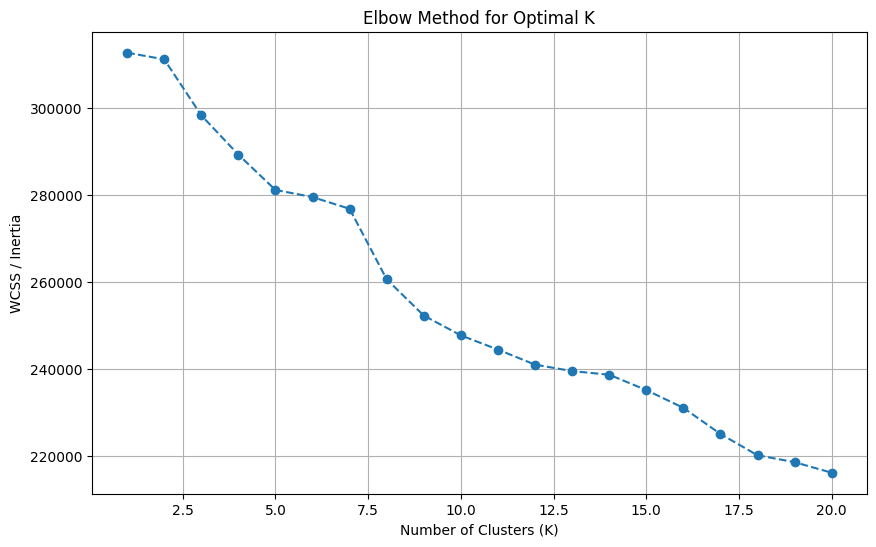

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the range of K to test (e.g., from 1 to 15 clusters)
max_k = 20
wcss = [] # Within-Cluster Sum of Squares

for i in range(1, max_k + 1):
    # Use n_init='auto' for robustness and random_state for reproducibility
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS / Inertia')
plt.grid(True)
plt.show()

--- Estatística de Hartigan para Escolha de K ---
     K  Estatística_Hartigan  Redução_Percentual
0    2                  0.04                4.32
1    3                  0.03                3.13
2    4                  0.03                2.89
3    5                  0.01                0.59
4    6                  0.01                0.97
5    7                  0.06                6.22
6    8                  0.03                3.30
7    9                  0.02                1.84
8   10                  0.01                1.34
9   11                  0.01                1.44
10  12                  0.01                0.62
11  13                  0.00                0.35
12  14                  0.01                1.50
13  15                  0.02                1.77
14  16                  0.03                2.67
15  17                  0.02                2.23
16  18                  0.01                0.72
17  19                  0.01                1.12


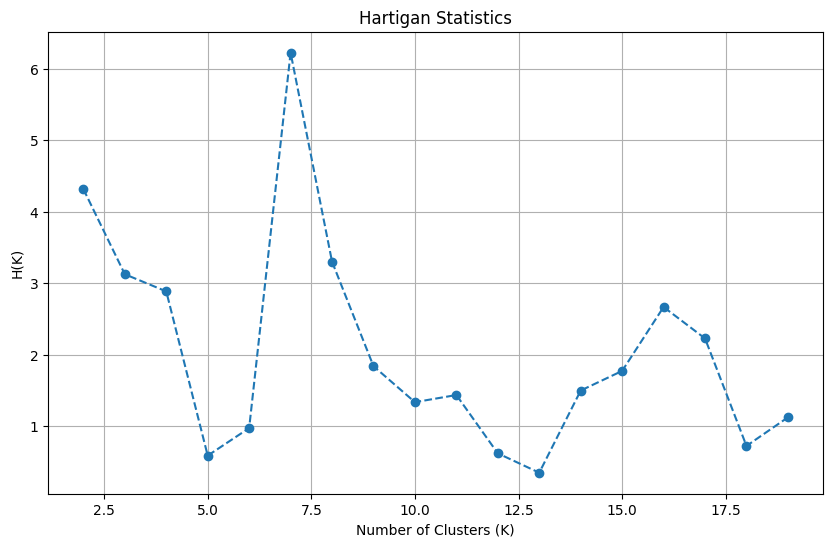

In [27]:
hartigan_stats = {}
max_k = len(wcss)

for k in range(2, max_k):
    wcss_k = wcss[k-1]
    wcss_k_plus_1 = wcss[k]

    hartigan = (wcss_k - wcss_k_plus_1) / wcss_k_plus_1
    
    hartigan_stats[k] = hartigan

hartigan_df = pd.DataFrame(
    list(hartigan_stats.items()), 
    columns=['K', 'Estatística_Hartigan']
)

hartigan_df['Redução_Percentual'] = hartigan_df['Estatística_Hartigan'] * 100

print("--- Estatística de Hartigan para Escolha de K ---")
print(hartigan_df.round(2))

plt.figure(figsize=(10, 6))
plt.plot(hartigan_df['K'], hartigan_df['Redução_Percentual'], marker='o', linestyle='--')
plt.title('Hartigan Statistics')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('H(K)')
plt.grid(True)
plt.show()

In [28]:
# Assuming optimal K is 5 based on the elbow plot
optimal_k = 7

# Initialize and train the final model
final_kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
final_kmeans.fit(X_scaled)

# Get the cluster labels for each bank
cluster_labels = final_kmeans.labels_

In [32]:
# 1. Add the cluster labels to the original DataFrame
df['Cluster'] = cluster_labels
df.columns = df.columns.astype(str)

# 2. Profile the clusters by calculating the mean of the original (unscaled) features for each cluster
cluster_profiles = df.groupby('Cluster')[X.columns].mean().sort_values(by='16000001', ascending=False)


print("\n--- Cluster Profiles (Centroid Means) ---")
print(cluster_profiles)

# 3. Save the results to a new CSV or update the SQLite database
df[['cnpj', 'Cluster']].to_csv('bank_clusters.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv', index=False)
# You can now use the 'Cluster' column as a categorical variable or for segmentation in your Ho and Saunders model.


--- Cluster Profiles (Centroid Means) ---
conta    10000007  11000006  11100009  11200002  11300005      11400008  \
Cluster                                                                   
1        0.458363  0.005700  0.003071  0.002825  0.000204  1.975646e-09   
2        0.446598  0.015854  0.000977  0.014777  0.000901  0.000000e+00   
6        0.393379  0.032944  0.000167  0.032777  0.000000  0.000000e+00   
3        0.238299  0.002965  0.001771  0.000868  0.000283  6.593153e-06   
4        0.666893  0.063812  0.000115  0.048199  0.025395  0.000000e+00   
5        0.482619  0.000857  0.000548  0.000309  0.000000  0.000000e+00   
0        0.991114  0.056546  0.033882  0.056033  0.000000  0.000000e+00   

conta    11500001      11900003  12000005  12100008  ...  90100006  90300002  \
Cluster                                              ...                       
1        0.000031  0.000000e+00  0.011105  0.004614  ...  0.026706  0.003322   
2        0.000030  0.000000e+00  0.029339

In [31]:
result = df[['cnpj', 'nome', 'Cluster', '10000007', '16000001', '30000001', '30900008', '31000000', '40000008', '49000009', '60000002', '70000009', '71000008', '80000006', '81000005', '81700006', '90000003', '90900000', '91000002', '91100005', '99999995', '39999993']]

result = result.rename(columns={
    '10000007': 'CIRCULANTE E REALIZAVEL A LONGO PRAZO', 
    '16000001': 'OPERAÇÕES DE CRÉDITO', 
    '30000001': 'COMPENSACAO ATIVA',
    '30900008': 'Controle',
    '31000000': 'CLASSIFICACAO DA CARTEIRA DE CREDITOS',
    '40000008': 'CIRCULANTE E EXIGIVEL A LONGO PRAZO',
    '49000009': 'OUTRAS OBRIGACOES',
    '60000002': 'PATRIMONIO LIQUIDO',
    '70000009': 'CONTAS DE RESULTADO CREDORAS',
    '71000008': 'RECEITAS OPERACIONAIS',
    '80000006': 'CONTAS DE RESULTADO DEVEDORAS',
    '81000005': 'DESPESAS OPERACIONAIS',
    '81700006': 'Despesas Administrativas',
    '90000003': 'COMPENSACAO PASSIVA',
    '90900000': 'Controle',
    '91000002': 'CLASSIFICACAO DA CARTEIRA DE CREDITOS',
    '91100005': 'Operacoes De Creditos E Arrendamento Mercantil',
    '99999995': 'TOTAL GERAL DO PASSIVO'
    })

